In [97]:
!pip install tifffile==2019.2.10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.7/125.7 kB 2.9 MB/s eta 0:00:0000:01
  Attempting uninstall: tifffile
    Found existing installation: tifffile 2021.7.2
    Uninstalling tifffile-2021.7.2:
      Successfully uninstalled tifffile-2021.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-image 0.19.2 requires tifffile>=2019.7.26, but you have tifffile 2019.2.10 which is incompatible.


In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import glob
import torch.optim as optim
import time
from torchvision import transforms as T, models
from osgeo import gdal
import rasterio
import cv2
%matplotlib inline
from PIL import Image
import tifffile

In [2]:
%ls Archive/

EuroSAT/         EuroSATallBands/ SatData/


In [3]:
data_dir = 'Archive/EuroSATallBands/'
print(os.listdir(data_dir))

['Forest', 'River', '.DS_Store', 'Highway', 'AnnualCrop', 'SeaLake', 'HerbaceousVegetation', 'Industrial', 'Residential', 'PermanentCrop', 'Pasture']


In [4]:
file_list = glob.glob(data_dir+"*")
for class_path in file_list:
    class_name = class_path.split("/")[-1]
    print(class_name)

Forest
River
Highway
AnnualCrop
SeaLake
HerbaceousVegetation
Industrial
Residential
PermanentCrop
Pasture


In [5]:
class CustomDataset(Dataset):
    def __init__(self,path,image_size):
        self.imgs_path = path
        file_list = glob.glob(self.imgs_path + "*")
        print(file_list)
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.tif"):
                self.data.append([img_path, class_name])
        print(self.data)
        self.class_map = {"AnnualCrop" : 0, "Forest": 1,"HerbaceousVegetation": 2,"Highway": 3,"Industrial":4,"Pasture":5,"PermanentCrop":6,"Residential":7,"River":8,"SeaLake":9}
        self.img_dim = image_size
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
#         im = Image.open(img_path)
#         img = rasterio.open(img_path)
#         img.read()
        img = np.asarray(tifffile.imread(img_path))
        img = img.astype(np.float32)
        class_id = self.class_map[class_name]
        transform = transforms.Compose([transforms.ToTensor()])
        img_tensor = transform(img)
        mean, std, var = torch.mean(img_tensor), torch.std(img_tensor), torch.var(img_tensor)
        img_tensor = (img_tensor-mean)/std
        class_id = torch.tensor([class_id])
        return img_tensor, class_id

In [6]:
from torch.utils.data.sampler import SubsetRandomSampler

def load_data(path, test_split, val_split, batch_size, input_size, shuffle_dataset=True,random_seed=42):
    dataset = CustomDataset(path,input_size)	
    # Creating data indices for training and test splits:
    dataset_size = len(dataset)
    train_test_indices = list(range(dataset_size))
    test_split = int(np.floor(test_split * dataset_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_test_indices)
    train_indices, test_indices = train_test_indices[test_split:], train_test_indices[:test_split]


   # Creating data indices for training and validation splits:
   
    train_data_size=len(train_indices)
    train_val_indices = list(range(train_data_size))
    val_split = int(np.floor(val_split * train_data_size))
    if shuffle_dataset :
        np.random.seed(random_seed)
        np.random.shuffle(train_val_indices)
    train_indices, val_indices = train_val_indices[val_split:], train_val_indices[:val_split]



    # Creating PT data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    data_loader_train = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                              sampler=train_sampler)
    data_loader_test = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=test_sampler)

    data_loader_val = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                    sampler=val_sampler)


   
    print(len(data_loader_train),len(data_loader_test),len(data_loader_val))
    
    return data_loader_train, data_loader_test, data_loader_val

In [7]:
data_loader_train, data_loader_test, data_loader_val=load_data(data_dir,.2,.2,32,(64,64))

print(len(data_loader_val))

['Archive/EuroSATallBands/Forest', 'Archive/EuroSATallBands/River', 'Archive/EuroSATallBands/Highway', 'Archive/EuroSATallBands/AnnualCrop', 'Archive/EuroSATallBands/SeaLake', 'Archive/EuroSATallBands/HerbaceousVegetation', 'Archive/EuroSATallBands/Industrial', 'Archive/EuroSATallBands/Residential', 'Archive/EuroSATallBands/PermanentCrop', 'Archive/EuroSATallBands/Pasture']
[['Archive/EuroSATallBands/Forest/Forest_2230.tif', 'Forest'], ['Archive/EuroSATallBands/Forest/Forest_1739.tif', 'Forest'], ['Archive/EuroSATallBands/Forest/Forest_343.tif', 'Forest'], ['Archive/EuroSATallBands/Forest/Forest_425.tif', 'Forest'], ['Archive/EuroSATallBands/Forest/Forest_2556.tif', 'Forest'], ['Archive/EuroSATallBands/Forest/Forest_2542.tif', 'Forest'], ['Archive/EuroSATallBands/Forest/Forest_431.tif', 'Forest'], ['Archive/EuroSATallBands/Forest/Forest_357.tif', 'Forest'], ['Archive/EuroSATallBands/Forest/Forest_2224.tif', 'Forest'], ['Archive/EuroSATallBands/Forest/Forest_1705.tif', 'Forest'], ['Arch

In [8]:
def plot_data_loader(data_loader, gridDims):
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = next(dataiter)
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

TypeError: Invalid shape (64, 64, 13) for image data

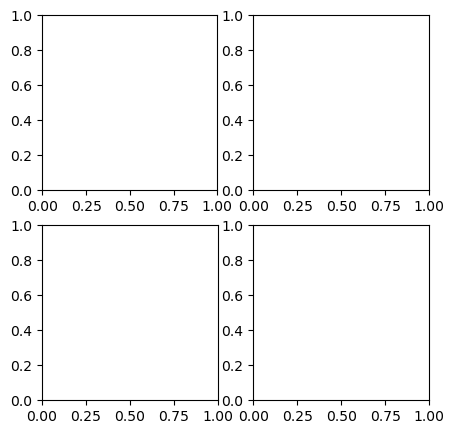

In [9]:
plot_data_loader(data_loader_test,[2,2])

In [10]:
import torchvision
import torch.nn as nn
from functools import partial


In [11]:
resnet_models = {18: torchvision.models.resnet18,
                 34: torchvision.models.resnet34,
                 50: torchvision.models.resnet18,
                 101: torchvision.models.resnet101,
                 152: torchvision.models.resnet152}
class Resnet_multichannel(nn.Module):
    def __init__(self, pretrained=True, encoder_depth=34, num_in_channels=4):
        super().__init__()
        
        if encoder_depth not in [18, 34, 50, 101, 152]:
            raise ValueError(f"Encoder depth {encoder_depth} specified does not match any existing Resnet models")
            
        model = resnet_models[encoder_depth](pretrained)
        
        ##For reference: layers to use (in order):
        # conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4, avgpool, fc
        
        # This is the most important line of code here. This increases the number of in channels for our network
        self.conv1 = self.increase_channels(model.conv1, num_in_channels)
        
        self.bn1 = model.bn1
        self.relu = model.relu
        self.maxpool = model.maxpool
        self.layer1 = model.layer1
        self.layer2 = model.layer2
        self.layer3 = model.layer3
        self.layer4 = model.layer4
        self.avgpool = model.avgpool
        self.fc = model.fc
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        
        return x
        
    def increase_channels(self, m, num_channels, copy_weights=0):


        """
        takes as input a Conv2d layer and returns the a Conv2d layer with `num_channels` input channels
        and all the previous weights copied into the new layer.
        """
        # number of input channels the new module should have
        new_in_channels = num_channels if num_channels is not None else m.in_channels + 1
        
        bias = False if m.bias is None else True
        
        # Creating new Conv2d layer
        new_m = nn.Conv2d(in_channels=new_in_channels, 
                          out_channels=m.out_channels, 
                          kernel_size=m.kernel_size, 
                          stride=m.stride, 
                          padding=m.padding,
                          bias=bias)
        
        
        with torch.no_grad():
            # Copying the weights from the old to the new layer
            new_m.weight[:, :m.in_channels, :, :] = m.weight.clone()
            #Copying the weights of the `copy_weights` channel of the old layer to the extra channels of the new layer
            for i in range(new_in_channels - m.in_channels):
                channel = m.in_channels + i
                new_m.weight[:, channel:channel+1, :, :] = m.weight[:, copy_weights:copy_weights+1, : :].clone()
            new_m.weight = nn.Parameter(new_m.weight)

        return new_m

In [12]:
def Resnet(encoder_depth, num_in_channels):
    """
    Returns just an architecture which can then be called in the usual way.
    For example:
    resnet34_4_channel = get_arch(34, 4)
    model = resnet34_4_channel(True)
    """
    return partial(Resnet_multichannel, encoder_depth=encoder_depth, num_in_channels=num_in_channels)

In [13]:
resnet34_13_channel = Resnet(18, 13)
model = resnet34_13_channel(True)
print("New input channels : ", model.conv1.in_channels)

/Users/priyangpatel/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/Users/priyangpatel/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


New input channels :  13


In [14]:
model

Resnet_multichannel(
  (conv1): Conv2d(13, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(in

In [15]:
optimizer = optim.Adam(model.parameters(),lr=0.001);
criterion = nn.CrossEntropyLoss()


In [16]:
d = "cpu"
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    d = "mps"
elif torch.cuda.is_available():
    d = "cuda:0"
device = torch.device(d)

print("Device: {}".format(device))

Device: mps


In [18]:
model.to(device)

num_epochs = 30
total_steps = len(data_loader_train)
t1 = time.time()
accuracies = []
losses = []

for epoch in range(num_epochs):
    ti = 0;
    total_correct = 0;
    tl = 0.0;
    for i, data in enumerate(data_loader_train):
        images, labels = data[0].to(device), data[1].to(device)
        labels=torch.flatten(labels)
        outputs = model(images)
        loss = criterion(outputs, labels)
        tl+=loss.item()
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        ti+=total
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        total_correct+= (predicted == labels).sum()
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),
                      (correct / total) * 100))
    accuracies.append(total_correct/ti*100.0)
    losses.append(float(tl)/ti)
           
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Epoch [1/30], Step [100/552], Loss: 0.5899, Accuracy: 87.50%
Epoch [1/30], Step [200/552], Loss: 0.6851, Accuracy: 87.50%
Epoch [1/30], Step [300/552], Loss: 0.6070, Accuracy: 78.12%
Epoch [1/30], Step [400/552], Loss: 0.0876, Accuracy: 96.88%
Epoch [1/30], Step [500/552], Loss: 0.0701, Accuracy: 100.00%
Epoch [2/30], Step [100/552], Loss: 0.0483, Accuracy: 100.00%
Epoch [2/30], Step [200/552], Loss: 0.2967, Accuracy: 90.62%
Epoch [2/30], Step [300/552], Loss: 0.0897, Accuracy: 100.00%
Epoch [2/30], Step [400/552], Loss: 0.5360, Accuracy: 84.38%
Epoch [2/30], Step [500/552], Loss: 0.1710, Accuracy: 93.75%
Epoch [3/30], Step [100/552], Loss: 0.2067, Accuracy: 96.88%
Epoch [3/30], Step [200/552], Loss: 0.3542, Accuracy: 90.62%
Epoch [3/30], Step [300/552], Loss: 0.2833, Accuracy: 93.75%
Epoch [3/30], Step [400/552], Loss: 0.5957, Accuracy: 93.75%
Epoch [3/30], Step [500/552], Loss: 0.0028, Accuracy: 100.00%
Epoch [4/30], Step [100/552], Loss: 0.1953, Accuracy: 93.75%
Epoch [4/30], Step [

Epoch [27/30], Step [300/552], Loss: 0.0338, Accuracy: 96.88%
Epoch [27/30], Step [400/552], Loss: 0.0000, Accuracy: 100.00%
Epoch [27/30], Step [500/552], Loss: 0.0246, Accuracy: 100.00%
Epoch [28/30], Step [100/552], Loss: 0.0002, Accuracy: 100.00%
Epoch [28/30], Step [200/552], Loss: 0.0046, Accuracy: 100.00%
Epoch [28/30], Step [300/552], Loss: 0.0287, Accuracy: 100.00%
Epoch [28/30], Step [400/552], Loss: 0.0019, Accuracy: 100.00%
Epoch [28/30], Step [500/552], Loss: 0.0203, Accuracy: 100.00%
Epoch [29/30], Step [100/552], Loss: 0.0019, Accuracy: 100.00%
Epoch [29/30], Step [200/552], Loss: 0.0040, Accuracy: 100.00%
Epoch [29/30], Step [300/552], Loss: 0.0008, Accuracy: 100.00%
Epoch [29/30], Step [400/552], Loss: 0.0085, Accuracy: 100.00%
Epoch [29/30], Step [500/552], Loss: 0.0208, Accuracy: 100.00%
Epoch [30/30], Step [100/552], Loss: 0.0013, Accuracy: 100.00%
Epoch [30/30], Step [200/552], Loss: 0.0009, Accuracy: 100.00%
Epoch [30/30], Step [300/552], Loss: 0.0044, Accuracy: 1

In [19]:
model.eval() 
with torch.no_grad(): 
 correct = 0
 total = 0
 for data in data_loader_test:
  images, labels = data[0].to(device), data[1].to(device)
  labels=torch.flatten(labels)
  outputs = model(images)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
print('Test Accuracy of the model on the {} test images: {} %'
  .format(total, (correct / total) * 100))

Test Accuracy of the model on the 5519 test images: 82.85921362565682 %


In [20]:
acc_list = [i.item() for i in accuracies]

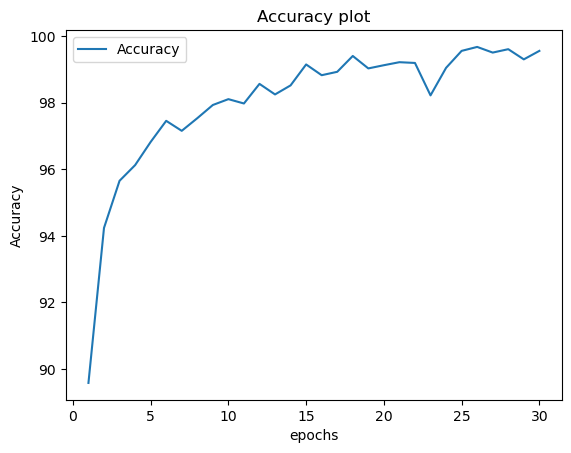

In [21]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')
plt.plot(range(1,num_epochs+1),acc_list)
plt.legend(['Accuracy'])

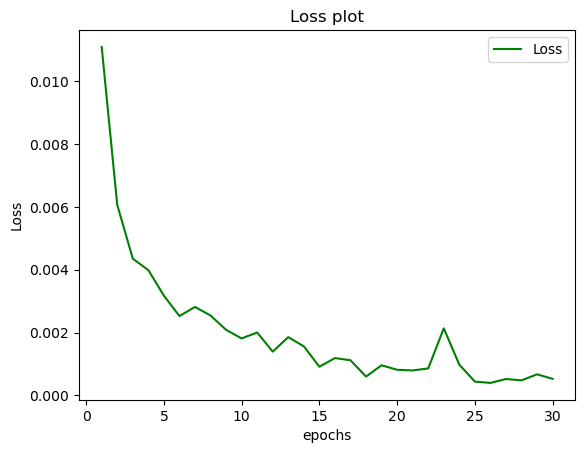

In [22]:
plt.figure()
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss plot')
plt.plot(range(1,num_epochs+1),losses,'g')
plt.legend(['Loss'])